# Informe Modelo para Predecir si aprobaran un curso de matematicas


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error

## Se cargan los datos

In [3]:
data = pd.read_csv('student_performance.csv')

In [4]:
print("Vista general del dataset:")
print(data.head())

Vista general del dataset:
  sex  age famsize Pstatus  Medu  Fedu     Mjob      Fjob  traveltime  \
0   F   18     GT3       A     4     4  at_home   teacher           2   
1   F   17     GT3       T     1     1  at_home     other           1   
2   F   15     LE3       T     1     1  at_home     other           1   
3   F   15     GT3       T     4     2   health  services           1   
4   F   16     GT3       T     3     3    other     other           1   

   studytime  failures internet romantic  goout  Walc  health  approved  
0          2         0       no       no      4     1       3         0  
1          2         0      yes       no      3     1       3         0  
2          2         3      yes       no      2     3       3         1  
3          3         0      yes      yes      2     1       5         1  
4          2         0       no       no      2     2       5         1  


In [5]:
print("\nInformacion general del dataset:")
print(data.info())


Informacion general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sex         1044 non-null   object
 1   age         1044 non-null   int64 
 2   famsize     1044 non-null   object
 3   Pstatus     1044 non-null   object
 4   Medu        1044 non-null   int64 
 5   Fedu        1044 non-null   int64 
 6   Mjob        1044 non-null   object
 7   Fjob        1044 non-null   object
 8   traveltime  1044 non-null   int64 
 9   studytime   1044 non-null   int64 
 10  failures    1044 non-null   int64 
 11  internet    1044 non-null   object
 12  romantic    1044 non-null   object
 13  goout       1044 non-null   int64 
 14  Walc        1044 non-null   int64 
 15  health      1044 non-null   int64 
 16  approved    1044 non-null   int64 
dtypes: int64(10), object(7)
memory usage: 138.8+ KB
None


### Se separan los datos de entrenamiento y de prueba 80% para entrenar y 20% para probar

In [6]:
# Tamaños de cada subconjunto
N = len(data)
cTrain = int(N * 0.8) 
cTest = N - cTrain
print(f"Total: {N}, Entrenamiento: {cTrain}, Prueba: {cTest}")

train_data, test_data = train_test_split(data, train_size=cTrain, test_size=cTest, random_state=42)

Total: 1044, Entrenamiento: 835, Prueba: 209


### Se grafican los datos para ver su estrucutura y así determinar el método de normalización

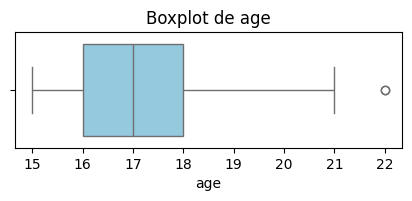

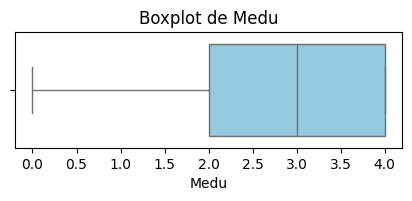

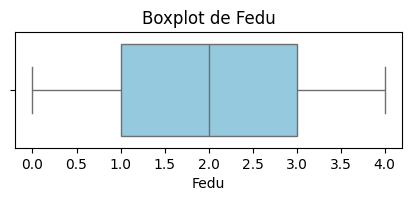

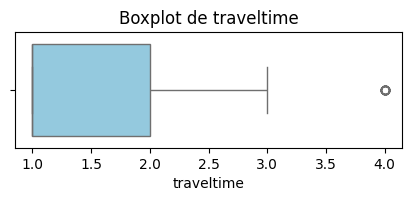

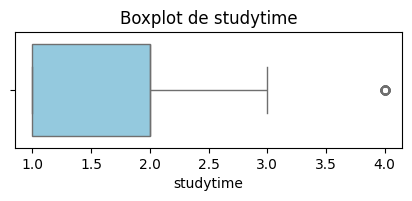

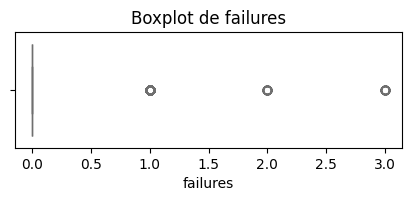

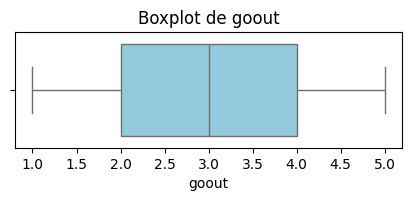

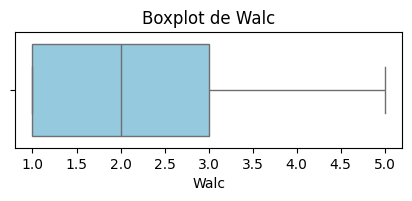

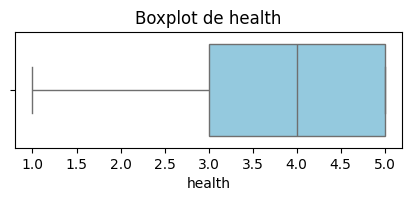

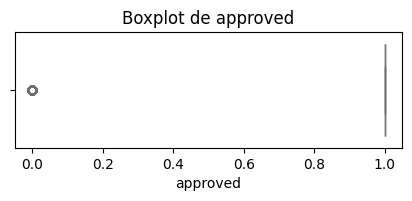

In [8]:
# Graficos de caja para detectar valores atipicos
for col in data.select_dtypes(include='number').columns:
    plt.figure(figsize=(5, 1.5))
    sns.boxplot(data=data, x=col, color='skyblue')
    plt.title(f'Boxplot de {col}')
    plt.show()


### Datos Categoricos 

In [10]:
categorica = ['sex', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'internet', 'romantic']

### Datos numericos clasificados según el analisis de los graficos

In [11]:
numerica_box = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures']
numerica_minmax = ['age']
numerica_std = ['goout', 'Walc', 'health']

## Se hace el Pipeline para los datos numericos con distribucion sesgada

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('boxcox', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

### Pipeline para variables numericas normales 

In [13]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

### Categoricos

In [14]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

## Se hace el Preprocessor con el pipeline númerico

In [15]:
preprocessor = ColumnTransformer(transformers=[
    ("num_std", num_pipeline, numerica_std),
    ("num_box", numeric_transformer, numerica_box),
    ("num_minmax", MinMaxScaler(), numerica_minmax),
    ("cat", cat_pipeline, categorica)
])

In [19]:
# Aplicar el pipeline
X_train = preprocessor.fit_transform(train_data)

In [17]:
print("Forma del conjunto transformado:", X_train.shape)

Forma del conjunto transformado: (835, 29)


In [18]:
y_train = train_data["approved"]
y_train.head()

531    1
256    1
350    0
60     1
930    1
Name: approved, dtype: int64

In [40]:
y_test = test_data["approved"]
y_test.head()

971    1
280    0
536    1
824    1
644    1
Name: approved, dtype: int64

# Entrenamiento de las redes neuronales

### Se crean los cinco modelos variando el tamaño de las redes

In [21]:
modelo1 = MLPClassifier(activation='relu', solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3,5), max_iter=1000, random_state=123)
modelo1.fit(X_train, y_train)
scores1 = cross_val_score(modelo1, X_train, y_train, cv=5, scoring='accuracy')
print(scores1)
scores1.mean()

[0.81437126 0.80239521 0.74251497 0.76646707 0.82634731]


np.float64(0.7904191616766468)

In [27]:
modelo2 = MLPClassifier(activation='relu', solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,5), max_iter=1000, random_state=123)
modelo2.fit(X_train, y_train)
scores2 = cross_val_score(modelo2, X_train, y_train, cv=5, scoring='accuracy')
print(scores2)
scores2.mean()

[0.74850299 0.71856287 0.68263473 0.7245509  0.73053892]


np.float64(0.7209580838323355)

In [28]:
modelo3 = MLPClassifier(activation='relu', solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3,5,5), max_iter=1000, random_state=123)
modelo3.fit(X_train, y_train)
scores3 = cross_val_score(modelo3, X_train, y_train, cv=5, scoring='accuracy')
print(scores3)
scores3.mean()

[0.76646707 0.74850299 0.77844311 0.70658683 0.82634731]


np.float64(0.7652694610778443)

In [29]:
modelo4 = MLPClassifier(activation='relu', solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,10), random_state=123)
modelo4.fit(X_train, y_train)
scores4 = cross_val_score(modelo4, X_train, y_train, cv=5, scoring='accuracy')
print(scores4)
scores4.mean()

[0.73652695 0.71856287 0.67065868 0.71257485 0.73053892]


np.float64(0.7137724550898203)

In [30]:
modelo5 = MLPClassifier(activation='relu', solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,10,5), random_state=123)
modelo5.fit(X_train, y_train)
scores5 = cross_val_score(modelo5, X_train, y_train, cv=5, scoring='accuracy')
print(scores5)
scores5.mean()

[0.7005988  0.70658683 0.65868263 0.67065868 0.69461078]


np.float64(0.6862275449101797)

### Ahora se usan los modelos con los datos de prueba

In [31]:
X_test = preprocessor.transform(test_data)
X_test

array([[ 1.58131733,  2.11768272,  1.01794422, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.71548128,  1.33248509,  1.01794422, ...,  1.        ,
         0.        ,  1.        ],
       [-0.15035476, -1.02310781, -0.37661431, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.01619081,  1.33248509,  1.01794422, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.71548128,  1.33248509,  0.32066496, ...,  1.        ,
         1.        ,  0.        ],
       [-1.88202685, -1.02310781,  0.32066496, ...,  0.        ,
         1.        ,  0.        ]], shape=(209, 29))

In [35]:
y_pred1 = modelo1.predict(X_test)
y_pred1

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1])

In [36]:
y_pred2 = modelo2.predict(X_test)
y_pred2

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1])

In [37]:
y_pred3 = modelo3.predict(X_test)
y_pred3

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1])

In [38]:
y_pred4 = modelo4.predict(X_test)
y_pred4

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [39]:
y_pred5 = modelo5.predict(X_test)
y_pred5

array([1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1])

### ya con estas variables se puede calcular que tan acertado es cada modelo (Accuracy)

In [44]:
y_pred1 = modelo1.predict(X_test)
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_pred1[mask]
mape1 = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
acc1 = 100 - mape1
print(f"Modelo 1 - MAPE: {mape1:.2f}% | Approx. Accuracy: {acc1:.2f}%")

Modelo 1 - MAPE: 16.11% | Approx. Accuracy: 83.89%


In [45]:
y_pred2 = modelo2.predict(X_test)
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_pred2[mask]
mape2 = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
acc2 = 100 - mape2
print(f"Modelo 2 - MAPE: {mape2:.2f}% | Approx. Accuracy: {acc2:.2f}%")

Modelo 2 - MAPE: 20.81% | Approx. Accuracy: 79.19%


In [46]:
y_pred3 = modelo3.predict(X_test)
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_pred3[mask]
mape3 = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
acc3 = 100 - mape3
print(f"Modelo 3 - MAPE: {mape3:.2f}% | Approx. Accuracy: {acc3:.2f}%")

Modelo 3 - MAPE: 15.44% | Approx. Accuracy: 84.56%


In [47]:
y_pred4 = modelo4.predict(X_test)
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_pred4[mask]
mape4 = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
acc4 = 100 - mape4
print(f"Modelo 4 - MAPE: {mape4:.2f}% | Approx. Accuracy: {acc4:.2f}%")

Modelo 4 - MAPE: 16.78% | Approx. Accuracy: 83.22%


In [48]:
y_pred5 = modelo5.predict(X_test)
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_pred5[mask]
mape5 = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
acc5 = 100 - mape5
print(f"Modelo 5 - MAPE: {mape5:.2f}% | Approx. Accuracy: {acc5:.2f}%")

Modelo 5 - MAPE: 21.48% | Approx. Accuracy: 78.52%


### Comparacion general en una tabla

In [49]:
modelos = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5']
mape_scores = [mape1, mape2, mape3, mape4, mape5]
accuracy_scores = [acc1, acc2, acc3, acc4, acc5]

In [50]:
resultados = pd.DataFrame({
    'Modelo': modelos,
    'MAPE (%)': [round(x, 2) for x in mape_scores],
    'Accuracy (%)': [round(x, 2) for x in accuracy_scores]
})

print("\nResultados comparativos de los modelos:\n")
display(resultados)


Resultados comparativos de los modelos:



,Modelo,MAPE (%),Accuracy (%)
0,Modelo 1,16.11,83.89
1,Modelo 2,20.81,79.19
2,Modelo 3,15.44,84.56
3,Modelo 4,16.78,83.22
4,Modelo 5,21.48,78.52


# El mejor modelo es:

In [51]:
mejor_modelo = resultados.loc[resultados['Accuracy (%)'].idxmax()]
print(f"El modelo mas preciso es {mejor_modelo['Modelo']} con un Accuracy de {mejor_modelo['Accuracy (%)']:.2f}%")

El modelo mas preciso es Modelo 3 con un Accuracy de 84.56%


## Variaciones de los hiperparámetros

para esto se usará el modelo 3 y se usara solver adam

In [52]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

modelo3_v1 = MLPRegressor(
    activation='relu',
    solver='adam',
    alpha=1e-5,
    hidden_layer_sizes=(3,5,5),
    random_state=123,
    max_iter=1000
)

In [53]:
modelo3_v1.fit(X_train, y_train)
scores_v1 = cross_val_score(modelo3_v1, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Scores del modelo 3_v1 (solver='adam'):", scores_v1)
print("Media del score:", scores_v1.mean())

Scores del modelo 3_v1 (solver='adam'): [-0.27213318 -0.27618466 -0.29474064 -0.28390346 -0.28050894]
Media del score: -0.28149417349428985


In [54]:
y_predv1 = modelo3_v1.predict(X_test)
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_predv1[mask]

In [55]:
mape_v1 = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
accuracy_v1 = 100 - mape_v1

In [56]:
print(f"\nModelo 3_v1 - Variacion del solver")
print(f"MAPE: {mape_v1:.2f}%")
print(f"Approximate Accuracy: {accuracy_v1:.2f}%")



Modelo 3_v1 - Variacion del solver
MAPE: 19.06%
Approximate Accuracy: 80.94%


 En este caso, el rendimiento se mantiene estable respecto al modelo base

In [57]:
modelo3_v2 = MLPRegressor(
    activation='logistic',
    solver='lbfgs',
    alpha=1e-5,
    hidden_layer_sizes=(3,5,5),
    random_state=123,
    max_iter=1000
)

In [58]:
modelo3_v2.fit(X_train, y_train)
scores_v2 = cross_val_score(modelo3_v2, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("\nScores del modelo 3_v2 (activation='logistic'):", scores_v2)
print("Media del score:", scores_v2.mean())


Scores del modelo 3_v2 (activation='logistic'): [-0.2669717  -0.29224467 -0.29123356 -0.285283   -0.26550112]
Media del score: -0.280246810402663


In [59]:
y_predv2 = modelo3_v2.predict(X_test)
mask = y_test != 0
safe_y_test = y_test[mask]
safe_y_pred = y_predv2[mask]

In [60]:
mape_v2 = mean_absolute_percentage_error(safe_y_test, safe_y_pred) * 100
accuracy_v2 = 100 - mape_v2

print(f"\nModelo 3_v2 - Variacion de activacion")
print(f"MAPE: {mape_v2:.2f}%")
print(f"Approximate Accuracy: {accuracy_v2:.2f}%")


Modelo 3_v2 - Variacion de activacion
MAPE: 19.55%
Approximate Accuracy: 80.45%


El cambio de funcion de activacion a 'logistic' reduce ligeramente la precision, mostrando un rendimiento un poco inferior al modelo base con 'relu'

# Resumen

En esta primera etapa se realizo el entrenamiento de cinco modelos de redes neuronales tipo Multilayer Perceptron (MLP) con el fin de predecir la variable objetivo “approved”, la cual indica si un estudiante fue aprobado o no.

Para ello, se utilizaron las variables:
sex, age, famsize, Pstatus, Medu, Fedu, Mjob, Fjob, traveltime, studytime, failures, internet, romantic, goout, Walc, health, y la propia approved como etiqueta de salida.

Los modelos se entrenaron variando la cantidad de capas ocultas y neuronas, con el solver 'lbfgs' y activación ReLU, utilizando validacion cruzada con 5 particiones (cv=5).
Posteriormente, se calculo el error porcentual medio absoluto (MAPE) y su precision aproximada (Accuracy) para cada modelo.

Los resultados mostraron que el Modelo 3 (estructura de capas (3,5,5)) obtuvo el mejor desempeño general, presentando la mayor precision entre los cinco modelos evaluados.

Finalmente, se exploraron variaciones en los hiperparametros del modelo 3, modificando el solver y la funcion de activacion. Los cambios no generaron mejoras significativas, por lo que se determino que la configuracion original del Modelo 3 es la mas adecuada para este conjunto de datos.